# Data loading

In [3]:
with open('README.convote', 'r') as file:
    readme_contents = file.read()
    print(readme_contents)

Congress votes network, part of the Koblenz Network Collection

This directory contains the TSV and related files of the convote network: In this network, nodes are politicians speaking in the United States Congress, and a directed edge denotes that a speaker mentions another speaker.  The weight of an edge (positive or negative) denotes whether the mention is in support of or opposition to the mentioned politician.  Multiple parallel edges are possible.  Loops are allowed, i.e., speakers may mention themselves. 


More information about the network is provided here: 
http://konect.cc/networks/convote

Files: 
    meta.convote -- Metadata about the network 
    out.convote -- The adjacency matrix of the network in whitespace-separated values format, with one edge per line
      The meaning of the columns in out.convote are: 
        First column: ID of from node 
        Second column: ID of to node
        Third column (if present): weight or multiplicity of edge
        Fourth column

In [4]:
with open('meta.convote', 'r') as file:
    readme_contents = file.read()
    print(readme_contents)

name:  Congress votes
code:  CO
url:  http://www.cs.cornell.edu/home/llee/data/convote.html
category:  Interaction
cite:  konect:convote
long-description:  In this network, nodes are politicians speaking in the United States Congress, and a directed edge denotes that a speaker mentions another speaker.  The weight of an edge (positive or negative) denotes whether the mention is in support of or opposition to the mentioned politician.  Multiple parallel edges are possible.  Loops are allowed, i.e., speakers may mention themselves. 
entity-names:  politician
relationship-names:  mention
extr:  convote
timeiso:  2005
tags:  #loop



In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

filepath = 'out.convote'

#timestamp not present
network_data = pd.read_csv(filepath, sep=' ', header=None, skiprows=1, names=['from_node', 'to_node', 'weight'])

print(network_data.head())


   from_node  to_node  weight
0          1        2       1
1          1        2       1
2          1        2       1
3          1        3      -1
4          1        4      -1


## Checking if data cleaning is necessary

In [6]:
network_data.shape

(764, 3)

In [7]:
network_data.isna().sum()

from_node    0
to_node      0
weight       0
dtype: int64

In [8]:
network_data.dtypes

from_node    int64
to_node      int64
weight       int64
dtype: object

# Graph plotting

In [6]:
G = nx.from_pandas_edgelist(network_data, 'from_node', 'to_node', ['weight'], create_using=nx.DiGraph())

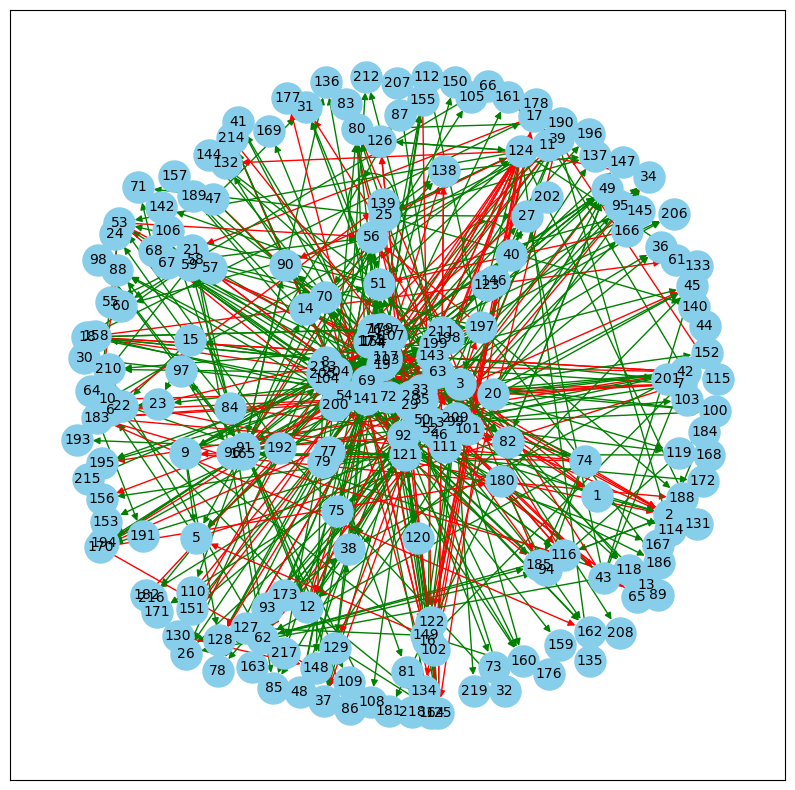

In [10]:
edge_colors = ['green' if data['weight'] >= 0 else 'red' for u, v, data in G.edges(data=True)]
plt.figure(figsize=(10,10))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', edge_color=edge_colors, font_size=10, node_size=500)
plt.show()

## Question 1: positive and negative relationships

In [11]:
!pip install python-louvain

  Using cached python-louvain-0.16.tar.gz (204 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=822737bfb6337fcb2c3185997d93b350eb08b34b798a61709b9f5d5e96d3dfe6
  Stored in directory: c:\users\tomin\appdata\local\pip\cache\wheels\11\c1\e7\f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain


In [12]:
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def graph_statistics(G):
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G, weight='weight')
    density = nx.density(G)
    average_degree = sum(dict(G.degree()).values()) / len(G.nodes())
    return modularity, density, average_degree

In [13]:
def relation_splitter(G):
    positive_edges = [(u, v, abs(d['weight'])) for u, v, d in G.edges(data=True) if d['weight'] > 0]
    negative_edges = [(u, v, abs(d['weight'])) for u, v, d in G.edges(data=True) if d['weight'] < 0]

    G_positive = nx.Graph()
    G_negative = nx.Graph()

    G_positive.add_weighted_edges_from(positive_edges)
    G_negative.add_weighted_edges_from(negative_edges)

    pos = nx.spring_layout(G)

    pos_partition = community_louvain.best_partition(G_positive, weight='weight')
    pos_cmap = cm.get_cmap('Greens', max(pos_partition.values()) + 1)
    pos_colors = [pos_cmap(pos_partition[node]) for node in G_positive.nodes()]

    neg_partition = community_louvain.best_partition(G_negative, weight='weight')
    neg_cmap = cm.get_cmap('Reds', max(neg_partition.values()) + 1)
    neg_colors = [neg_cmap(neg_partition[node]) for node in G_negative.nodes()]

    
    print("Positive graph:", graph_statistics(G_positive))
    print("Negative graph", graph_statistics(G_negative))
    
    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 1)
    nx.draw_networkx(G_positive, pos, node_color=pos_colors, with_labels=True, font_size=10, node_size=500, edge_color='darkgreen')
    plt.title('Positive Relationships')

    plt.subplot(2, 2, 2)
    nx.draw_networkx(G_negative, pos, node_color=neg_colors, with_labels=True, font_size=10, node_size=500, edge_color='darkred')
    plt.title('Negative Relationships')
    
    plt.subplot(2, 2, 3)
    nx.draw_networkx(G_positive, node_color=pos_colors, with_labels=True, font_size=10, node_size=500, edge_color='darkgreen')
    plt.title('Positive Relationships')

    plt.subplot(2, 2, 4)
    nx.draw_networkx(G_negative, node_color=neg_colors, with_labels=True, font_size=10, node_size=500, edge_color='darkred')
    plt.title('Negative Relationships')

    plt.show()

Positive graph: (0.6075432230029586, 0.018599660198515604, 3.9245283018867925)


C:\Users\tomin\AppData\Local\Temp\ipykernel_46396\4057984449.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pos_cmap = cm.get_cmap('Greens', max(pos_partition.values()) + 1)
C:\Users\tomin\AppData\Local\Temp\ipykernel_46396\4057984449.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  neg_cmap = cm.get_cmap('Reds', max(neg_partition.values()) + 1)


Negative graph (0.7202812472705039, 0.02298109965635739, 2.2061855670103094)


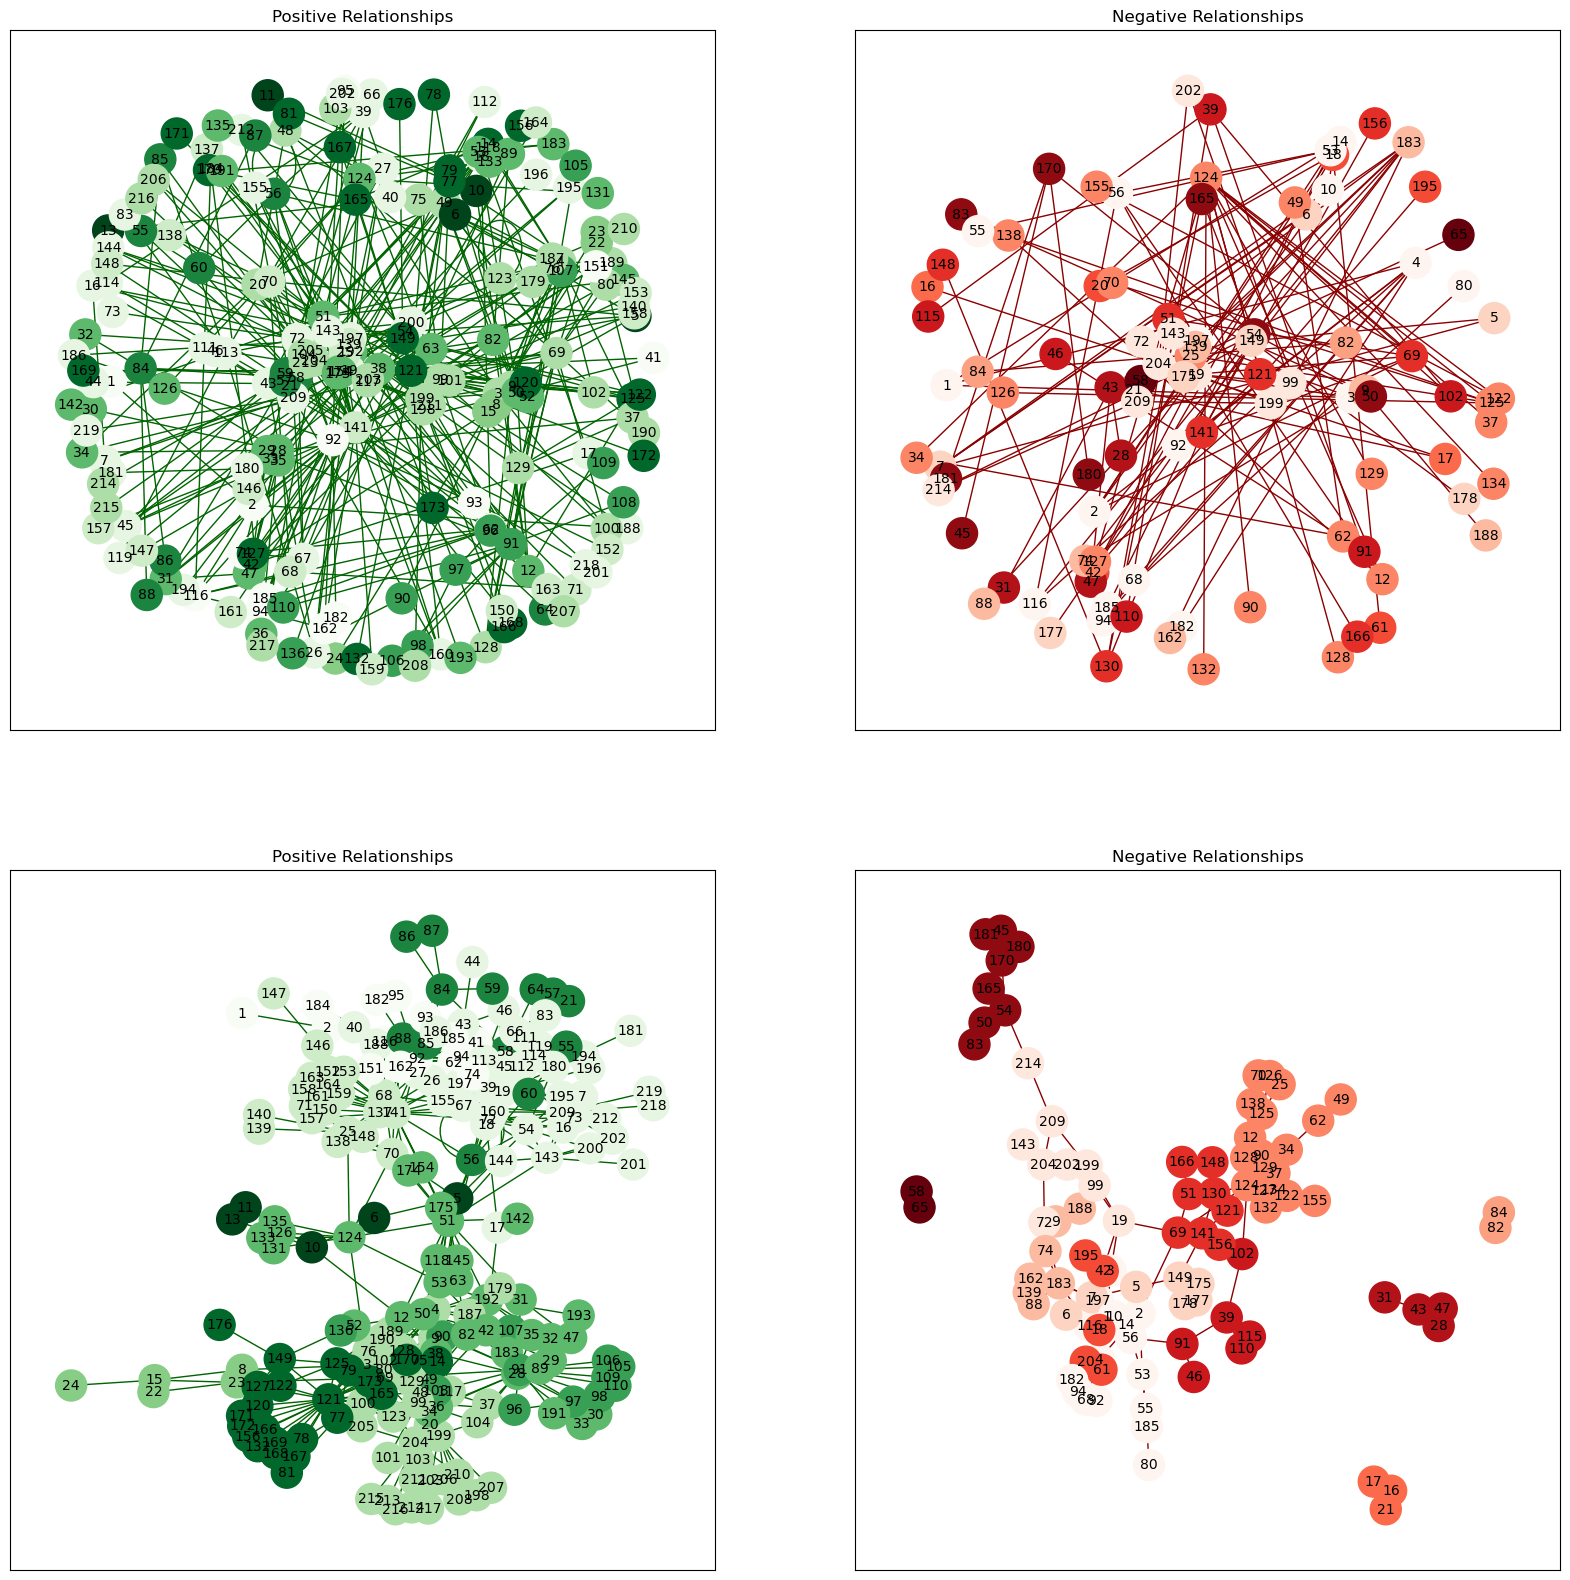

In [14]:
relation_splitter(G)

## Question 2: centralities

C:\Users\roder\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
C:\Users\roder\AppData\Local\Temp\ipykernel_6120\1950647884.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis),
C:\Users\roder\AppData\Local\Temp\ipykernel_6120\1950647884.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm

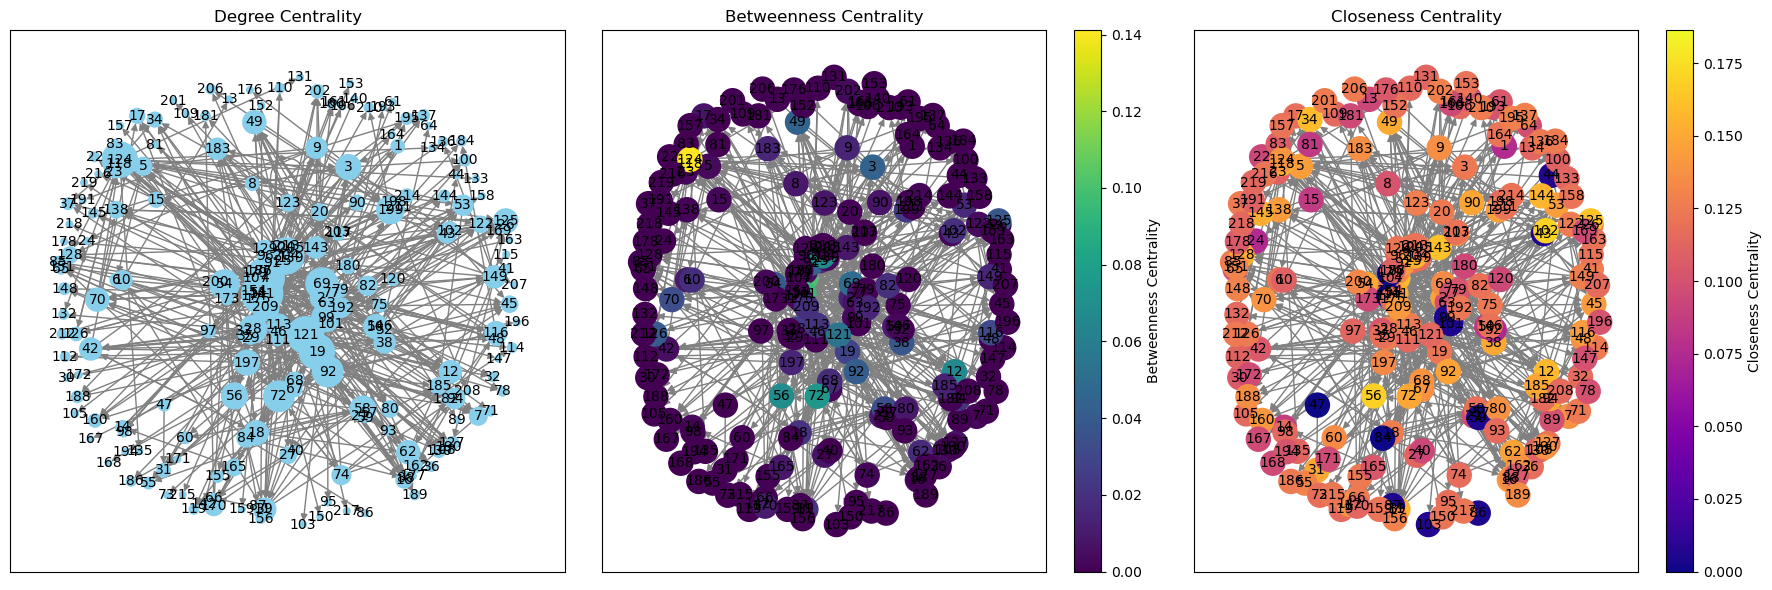

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

degree_sizes = [v * 5000 for v in degree_centrality.values()]
betweenness_values = list(betweenness_centrality.values())
closeness_values = list(closeness_centrality.values())

betweenness_colors = plt.cm.viridis(betweenness_values)
closeness_colors = plt.cm.plasma(closeness_values)

from matplotlib.colors import Normalize
import numpy as np

norm = Normalize(vmin=min(betweenness_centrality.values()), vmax=max(betweenness_centrality.values()))
betweenness_colors = plt.cm.viridis(norm(list(betweenness_centrality.values())))

norm_closeness = Normalize(vmin=min(closeness_centrality.values()), vmax=max(closeness_centrality.values()))
closeness_colors = plt.cm.plasma(norm_closeness(list(closeness_centrality.values())))

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                 node_size=degree_sizes, node_color='skyblue',
                 edge_color='grey', font_size=10)
plt.title('Degree Centrality')

plt.subplot(1, 3, 2)
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                 node_color=betweenness_colors, node_size=300,
                 edge_color='grey', font_size=10, cmap=plt.cm.viridis)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis),
             label='Betweenness Centrality')
plt.title('Betweenness Centrality')

plt.subplot(1, 3, 3)
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                 node_color=closeness_colors, node_size=300,
                 edge_color='grey', font_size=10, cmap=plt.cm.plasma)
plt.colorbar(plt.cm.ScalarMappable(norm=norm_closeness, cmap=plt.cm.plasma),
             label='Closeness Centrality')
plt.title('Closeness Centrality')

plt.tight_layout()
plt.show()


## Question 3: 

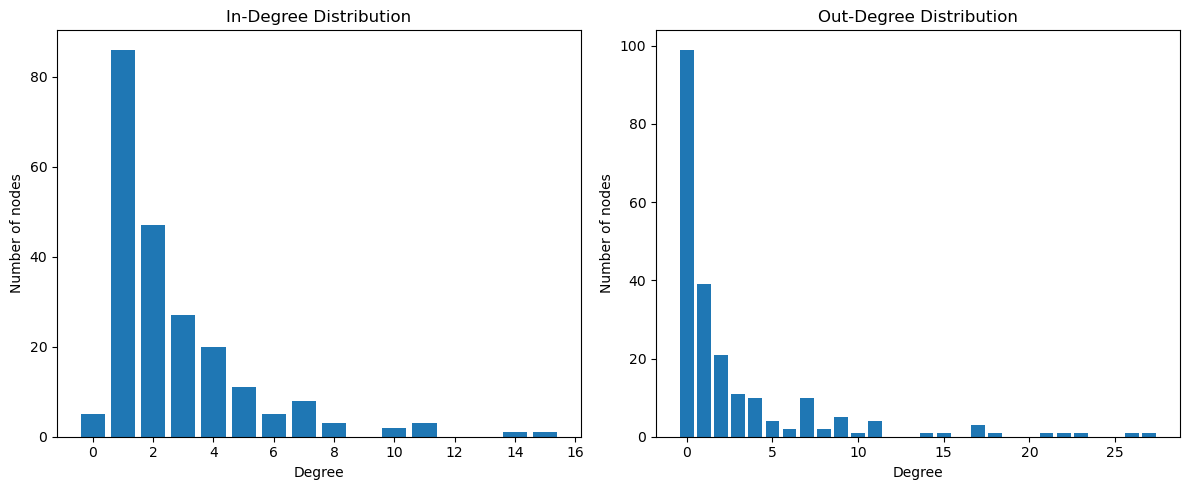

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 21, 22, 23, 26, 27] [99, 39, 21, 11, 10, 4, 2, 10, 2, 5, 1, 4, 1, 1, 3, 1, 1, 1, 1, 1, 1]


In [16]:
import collections

in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_degree_values = sorted(set(in_degrees.values()))
in_degree_hist = [list(in_degrees.values()).count(x) for x in in_degree_values]

out_degree_values = sorted(set(out_degrees.values()))
out_degree_hist = [list(out_degrees.values()).count(x) for x in out_degree_values]

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.bar(in_degree_values, in_degree_hist)
plt.title('In-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.subplot(122)
plt.bar(out_degree_values, out_degree_hist)
plt.title('Out-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

plt.tight_layout()
plt.show()
print(out_degree_values, out_degree_hist)


In [17]:
pip install powerlaw


Calculating best minimal value for power law fit


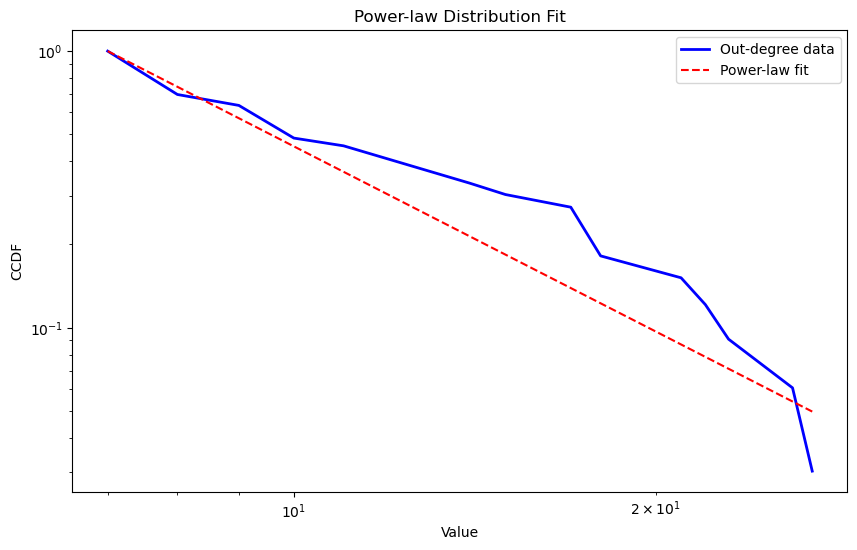

Power-law alpha parameter: 3.22292035179685
Likelihood of power-law fit compared to exponential fit: (1.5908491600959662, 0.4287718670094911)


In [18]:
import powerlaw
import numpy as np
import matplotlib.pyplot as plt
out_degree_values1 =  [x + 1e-5 for x in sorted(out_degrees.values())]

fit = powerlaw.Fit(out_degree_values1)

plt.figure(figsize=(10, 6))
fit.plot_ccdf(color='b', linewidth=2, label='Out-degree data')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=plt.gca(), label='Power-law fit')

plt.xlabel('Value')
plt.ylabel('CCDF')
plt.title('Power-law Distribution Fit')
plt.legend()
plt.show()

print("Power-law alpha parameter:", fit.power_law.alpha)

likelihood_ratio = fit.distribution_compare('power_law', 'exponential')

print("Likelihood of power-law fit compared to exponential fit:", likelihood_ratio)

Calculating best minimal value for power law fit


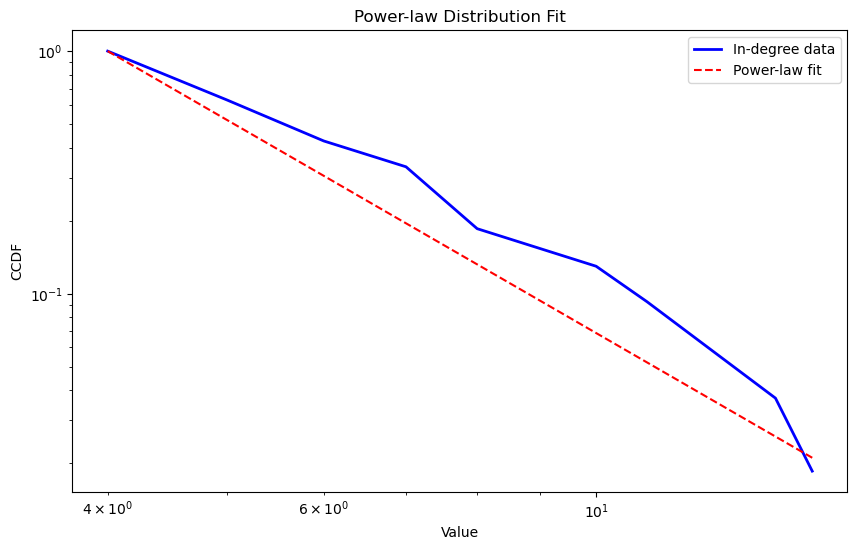

Power-law alpha parameter: 3.922055456781799
Likelihood of power-law fit compared to exponential fit: (3.472833620708208, 0.12953250162386012)


In [19]:
in_degree_values1 =   [x + 1e-5 for x in sorted(in_degrees.values())]
in_degree_hist1 = [list(in_degrees.values()).count(x) for x in in_degree_values1]

fit = powerlaw.Fit(in_degree_values1)

plt.figure(figsize=(10, 6))
fit.plot_ccdf(color='b', linewidth=2, label='In-degree data')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=plt.gca(), label='Power-law fit')

plt.xlabel('Value')
plt.ylabel('CCDF')
plt.title('Power-law Distribution Fit')
plt.legend()
plt.show()

print("Power-law alpha parameter:", fit.power_law.alpha)

likelihood_ratio = fit.distribution_compare('power_law', 'exponential')

print("Likelihood of power-law fit compared to exponential fit:", likelihood_ratio)

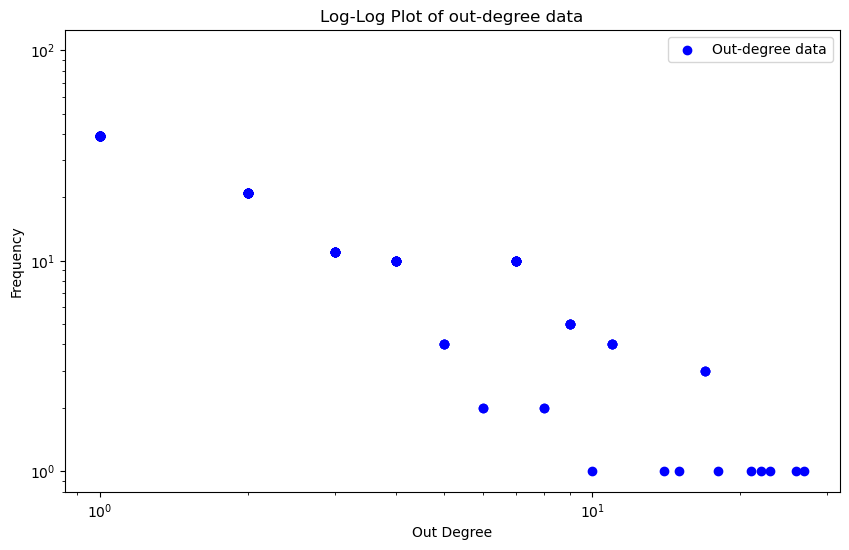

In [20]:
out_degree_values1 = sorted(out_degrees.values())

out_degree_hist1 = [list(out_degrees.values()).count(x) for x in out_degree_values1]


plt.figure(figsize=(10, 6))
plt.scatter(out_degree_values1, out_degree_hist1, color='b', label='Out-degree data')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Out Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Plot of out-degree data')
plt.legend()
plt.show()

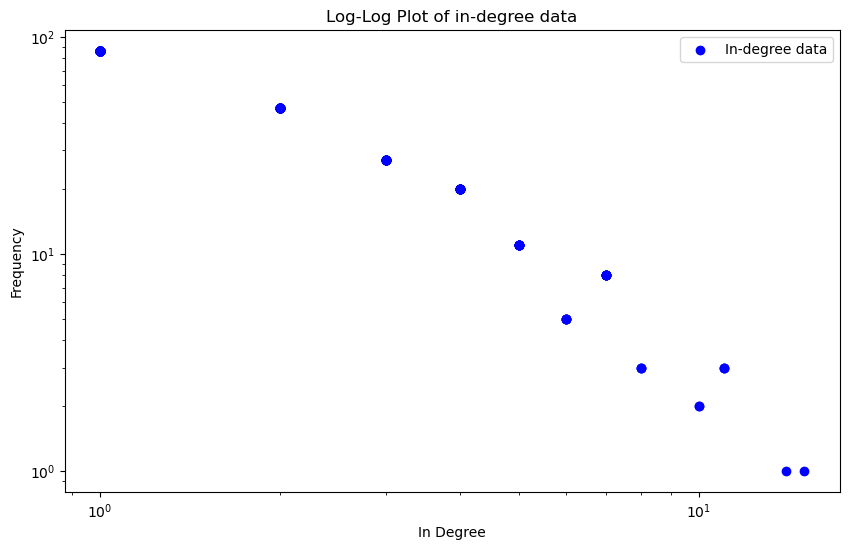

In [21]:
in_degree_values1 = sorted(in_degrees.values())
in_degree_hist1 = [list(in_degrees.values()).count(x) for x in in_degree_values1]


plt.figure(figsize=(10, 6))
plt.scatter(in_degree_values1, in_degree_hist1, color='b', label='In-degree data')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('In Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Plot of in-degree data')
plt.legend()
plt.show()

In [22]:
pip install matplotlib-venn


Note: you may need to restart the kernel to use updated packages.


In [23]:
in_degree0_set = {key for key, value in in_degrees.items() if value == 0}
out_degree0_set = {key for key, value in out_degrees.items() if value == 0}

in_degree_set = {key for key, value in in_degrees.items() if value > 0}
out_degree_set = {key for key, value in out_degrees.items() if value > 0}

recipients = in_degree_set.intersection(out_degree0_set)
broadcasters = in_degree0_set.intersection(out_degree_set)

print("number of in degree0 ", len(in_degree0_set))
print("number of in degree ", len(in_degree_set))
print("number of out degree0 ", len(out_degree0_set))
print("number of out degree ", len(out_degree_set))
print("number of recipients ", len(recipients))
print("number of broadcasters ", len(broadcasters))

print(recipients)
print(broadcasters)


number of in degree0  5
number of in degree  214
number of out degree0  99
number of out degree  120
number of recipients  99
number of broadcasters  5
{11, 13, 22, 24, 26, 30, 31, 32, 34, 36, 37, 41, 44, 45, 48, 55, 61, 64, 66, 71, 73, 78, 81, 83, 85, 86, 87, 88, 89, 95, 98, 100, 103, 105, 106, 108, 109, 112, 114, 115, 118, 119, 128, 131, 132, 133, 134, 135, 136, 137, 140, 142, 144, 145, 147, 148, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164, 167, 168, 169, 171, 172, 176, 177, 178, 181, 184, 186, 188, 189, 190, 191, 193, 194, 195, 196, 201, 206, 207, 208, 210, 212, 215, 216, 217, 218, 219}
{174, 47, 179, 84, 57}


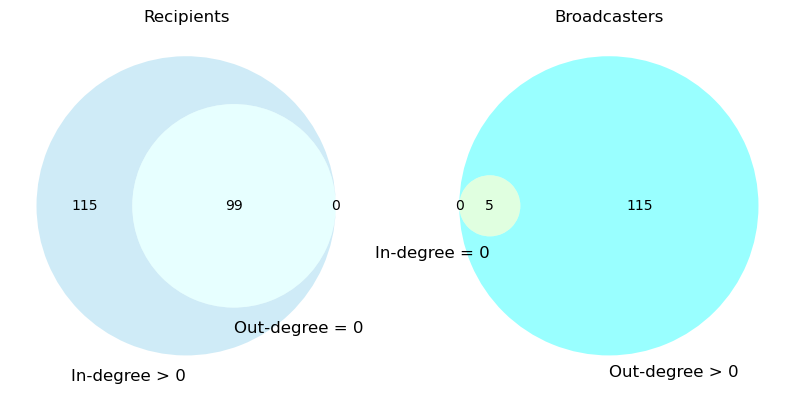

In [24]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

venn2([in_degree_set, out_degree0_set], ax=axs[0], set_labels=('In-degree > 0', 'Out-degree = 0'), set_colors=('skyblue', 'lightgreen'))
axs[0].set_title('Recipients')

venn2([in_degree0_set, out_degree_set], ax=axs[1], set_labels=('In-degree = 0', 'Out-degree > 0'), set_colors=('gold', 'cyan'))
axs[1].set_title('Broadcasters')

plt.show()

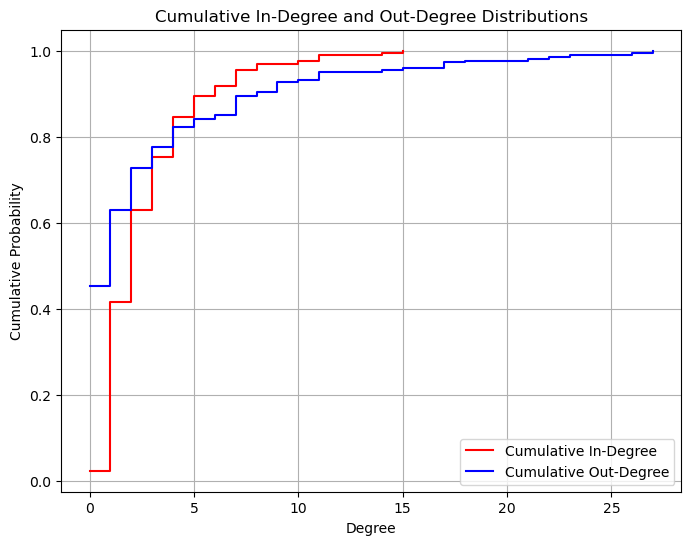

In [25]:
import numpy as np

def cumulative_distribution(degrees):
    counts = collections.Counter(degrees)
    sorted_degrees = sorted(counts.items())
    cumsum = np.cumsum([count for _, count in sorted_degrees])
    total = sum(counts.values())
    return [degree for degree, _ in sorted_degrees], cumsum / total

in_degree_values, in_degree_cum_prob = cumulative_distribution(list(in_degrees.values()))
out_degree_values, out_degree_cum_prob = cumulative_distribution(list(out_degrees.values()))

plt.figure(figsize=(8, 6))
plt.step(in_degree_values, in_degree_cum_prob, where="post", label='Cumulative In-Degree', color='red')
plt.step(out_degree_values, out_degree_cum_prob, where="post", label='Cumulative Out-Degree', color='blue')
plt.title('Cumulative In-Degree and Out-Degree Distributions')
plt.xlabel('Degree')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()


SSK

In [36]:
def positive_negative_graph(G):
    positive_edges = [(u, v, abs(d['weight'])) for u, v, d in G.edges(data=True) if d['weight'] > 0]
    negative_edges = [(u, v, abs(d['weight'])) for u, v, d in G.edges(data=True) if d['weight'] < 0]

    G_positive = nx.DiGraph()
    G_negative = nx.DiGraph()

    G_positive.add_weighted_edges_from(positive_edges)
    G_negative.add_weighted_edges_from(negative_edges)

    return G_positive, G_negative

G_pos, G_neg = positive_negative_graph(G)
ssk_pos = list(nx.strongly_connected_components(G_pos))
print(len(ssk_pos))
ssk_pos_more_than1 = [(len(ssk), ssk)for ssk in ssk_pos if len(ssk) > 1]
print('positive:', ssk_pos_more_than1)

ssk_neg = list(nx.strongly_connected_components(G_neg))
print(len(ssk_neg))
ssk_neg_more_than1 = [(len(ssk), ssk)for ssk in ssk_neg if len(ssk) > 1]
print('negative:', ssk_neg_more_than1)


126
positive: [(2, {40, 27}), (2, {77, 79}), (84, {2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 18, 19, 20, 25, 28, 29, 33, 35, 38, 42, 46, 49, 50, 51, 52, 54, 56, 58, 62, 63, 67, 68, 69, 70, 72, 74, 75, 76, 82, 90, 91, 92, 93, 94, 96, 97, 104, 107, 111, 113, 116, 117, 120, 121, 123, 124, 126, 127, 129, 139, 141, 143, 146, 149, 154, 165, 170, 173, 175, 185, 187, 192, 197, 198, 199, 200, 203, 204, 205, 209, 211, 213, 214}), (2, {99, 101})]
88
negative: [(2, {116, 4}), (2, {19, 69}), (3, {138, 125, 126}), (3, {124, 12, 127}), (2, {16, 17}), (2, {18, 42}), (2, {65, 58})]


In [66]:
def assign_color_to_scc(sccs):
    colors_to_choose = [
    "red", 
    "green", 
    "blue", 
    "cyan", 
    "magenta", 
    "yellow",   
    "orange", 
    "purple", 
    "brown", 
    "pink",  
    "olive", 
    "maroon", 
    "navy", 
    "teal", 
    "lime", 
    "aqua", 
    "fuchsia",
    "gold"
    ]
    
    colors = dict()
    for scc in sccs:
        color = ''
        if len(scc) == 1:
                color = 'gray'
        else:
            color = colors_to_choose.pop(0)
        for node in scc:
            colors[node] = color
    return colors

ssk_pos_colors = assign_color_to_scc(ssk_pos)
ssk_neg_colors = assign_color_to_scc(ssk_neg)
ssk_pos_colors

         

{162: 'gray',
 45: 'gray',
 41: 'gray',
 95: 'gray',
 26: 'gray',
 114: 'gray',
 66: 'gray',
 39: 'gray',
 40: 'red',
 27: 'red',
 137: 'gray',
 138: 'gray',
 140: 'gray',
 71: 'gray',
 148: 'gray',
 150: 'gray',
 151: 'gray',
 152: 'gray',
 55: 'gray',
 60: 'gray',
 191: 'gray',
 183: 'gray',
 53: 'gray',
 118: 'gray',
 142: 'gray',
 16: 'gray',
 195: 'gray',
 212: 'gray',
 11: 'gray',
 125: 'gray',
 13: 'gray',
 218: 'gray',
 219: 'gray',
 160: 'gray',
 202: 'gray',
 7: 'gray',
 144: 'gray',
 201: 'gray',
 145: 'gray',
 31: 'gray',
 153: 'gray',
 155: 'gray',
 85: 'gray',
 119: 'gray',
 83: 'gray',
 157: 'gray',
 158: 'gray',
 159: 'gray',
 161: 'gray',
 88: 'gray',
 147: 'gray',
 163: 'gray',
 164: 'gray',
 131: 'gray',
 133: 'gray',
 206: 'gray',
 207: 'gray',
 208: 'gray',
 210: 'gray',
 102: 'gray',
 128: 'gray',
 30: 'gray',
 32: 'gray',
 34: 'gray',
 36: 'gray',
 37: 'gray',
 48: 'gray',
 17: 'gray',
 78: 'gray',
 190: 'gray',
 80: 'gray',
 81: 'gray',
 77: 'green',
 79: 'green

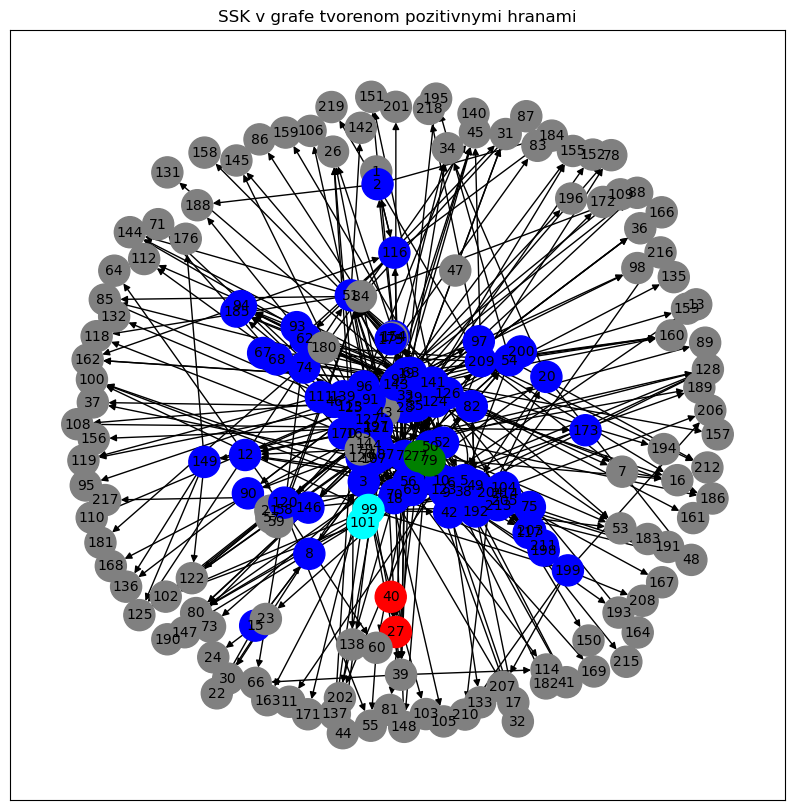

In [117]:
plt.figure(figsize=(10,10))
nx.draw_networkx(G_pos, with_labels=True, node_color=[ssk_pos_colors[node] for node in G_pos.nodes()], font_size=10, node_size=500)
plt.title('SSK v grafe tvorenom pozitivnymi hranami')
plt.show()

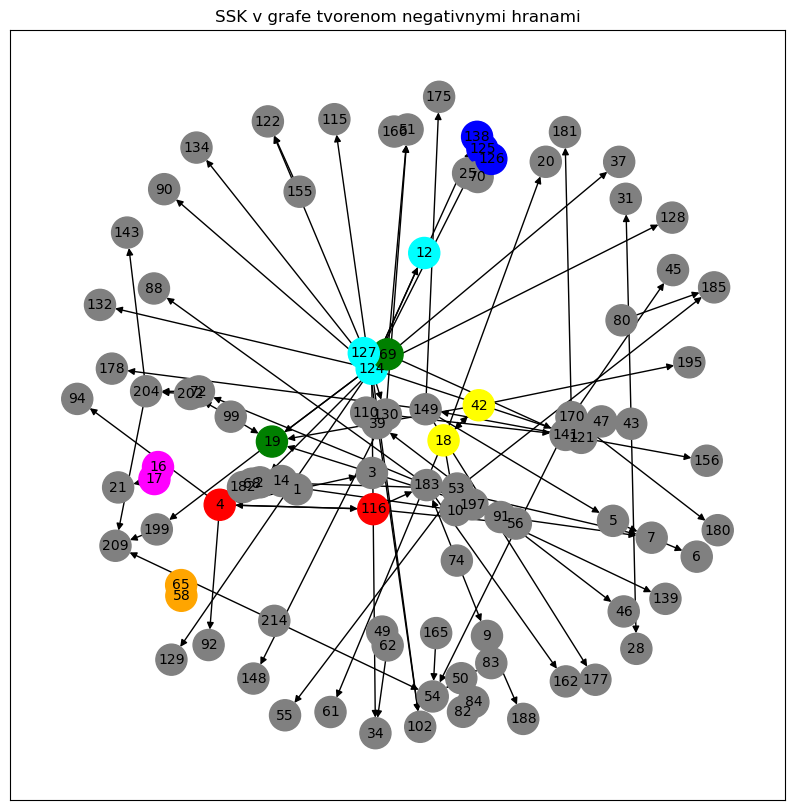

In [148]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_neg)
nx.draw_networkx(G_neg,pos, with_labels=True, node_color=[ssk_neg_colors[node] for node in G_neg.nodes()], font_size=10, node_size=500)
plt.title('SSK v grafe tvorenom negativnymi hranami')
plt.show()

[(7, 5), (7, 6), (8, 7), (10, 9), (18, 17), (20, 19), (21, 20), (34, 24), (58, 28), (69, 68), (71, 67), (71, 69), (71, 70), (83, 82), (89, 28), (109, 106), (109, 108), (109, 81), (109, 22), (109, 80), (109, 59), (109, 68), (109, 58), (109, 37), (109, 69), (109, 83), (109, 65), (109, 84), (109, 85), (109, 57), (109, 54), (109, 86), (109, 55), (109, 56), (109, 21), (109, 23), (109, 35), (109, 38), (109, 18), (109, 7), (109, 87), (109, 61), (109, 74), (109, 27), (109, 29), (109, 82), (109, 98), (109, 28), (109, 66), (109, 2), (109, 4), (109, 8), (109, 101), (109, 34), (109, 1), (109, 42), (109, 40), (109, 103), (109, 25), (109, 104), (109, 32), (109, 102), (109, 17), (109, 6), (109, 9), (109, 105), (109, 0), (109, 62), (109, 10), (109, 11), (109, 12), (109, 52), (109, 53), (109, 99), (109, 13), (109, 14), (109, 15), (109, 16), (109, 39), (109, 44), (109, 45), (109, 46), (109, 41), (109, 47), (109, 48), (109, 50), (109, 51), (109, 60), (109, 63), (109, 64), (109, 43), (109, 5), (109, 72), 

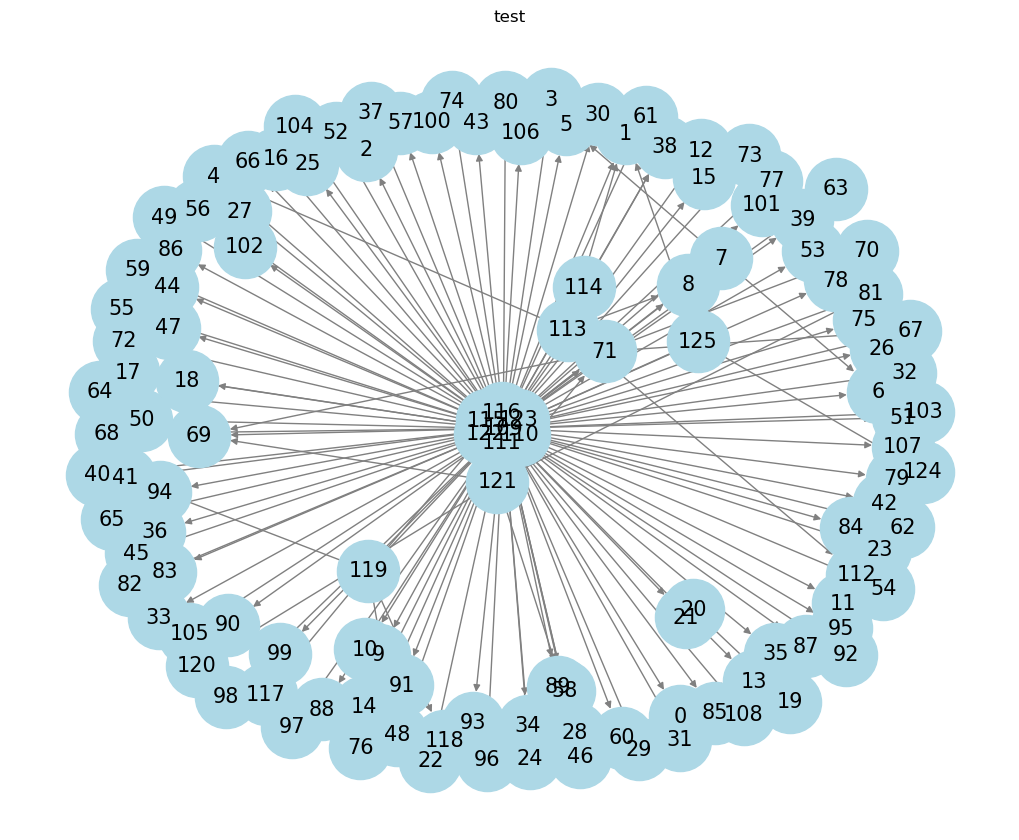

In [149]:
def condense_graph(G):
    sccs = list(nx.strongly_connected_components(G))
    
    G_condensed = nx.condensation(G, sccs)
    
    return G_condensed


def draw_graph(G, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=15)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d.get('weight', '') for u, v, d in G.edges(data=True)})
    plt.title(title)
    plt.show()

G_pos_condensed = condense_graph(G_pos)
print(G_pos_condensed.edges(), 'dadadadadad',G_pos_condensed.nodes())
draw_graph(G_pos_condensed, 'test')

## Question 3: How does self-mentioning affect the network ?
    How do politicians talk about themselves ? Do they have a tendency of talking good about themselves ?
    Does self-mentioning correlate with the centrality of a politician within the network ?

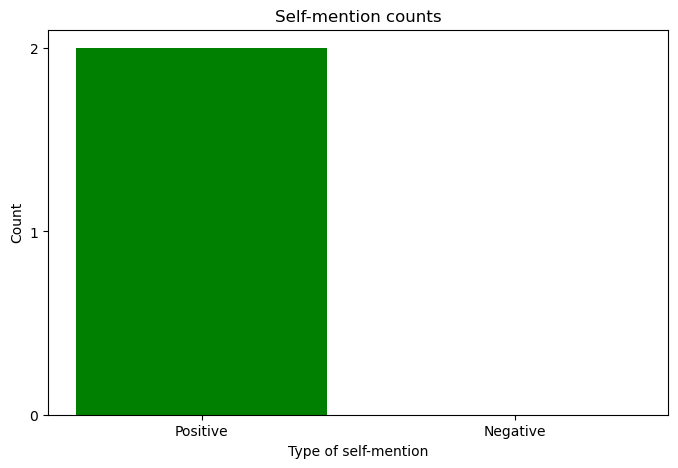

In [26]:
import networkx as nx
self_mentions = {node: 0 for node in G.nodes()}
total_self_mentions = 0
positive_self_mentions = 0
negative_self_mentions = 0
self_mentioning_politicians = []

for u, v, data in G.edges(data=True):
    w = data['weight']
    if u == v:
        total_self_mentions += 1
        self_mentioning_politicians.append((u, w))
        if w:
            self_mentions[u] += 1
            positive_self_mentions += 1
        else:
            self_mentions[u] += 1
            negative_self_mentions += 1

categories = ['Positive', 'Negative']
values = [positive_self_mentions, negative_self_mentions]

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['green', 'red'])
plt.title('Self-mention counts')
plt.xlabel('Type of self-mention')
plt.ylabel('Count')
plt.yticks(range(0, max(values) + 1, 1))
plt.show()

Conclusion:
There is not enough self-mentioning politicians to proceed with this analysis and extract useful insight and draw conclusions.